# A quick demo of `expt`

DISCLAIMER: Many things including API and default behaviors are subject to change.

## 0. Data Preparation Part (can be skipped)

Let's grab some raw log data of training DQN agents that is publicly available:

https://github.com/openai/baselines-results/blob/master/dqn_results.ipynb

In [1]:
# https://github.com/openai/baselines-results/blob/master/dqn_results.ipynb
results_url = "https://openaisciszymon.blob.core.windows.net/dqn-blogpost/results.pkl"
download_path = "dqn_results.pkl"
! [ -e "{download_path}" ] || curl -L {results_url} -o {download_path}

with open(download_path, "rb") as f:
    import pickle
    run_to_episode_data = pickle.load(f)

Let's convert this pickle data into a CSV file, one into each directory.

In [2]:
import pandas as pd
try:
    from tqdm.auto import tqdm
except ImportError:
    tqdm = lambda _: _

def process_data():
    for k in tqdm(sorted(run_to_episode_data.keys())):
        df = pd.DataFrame(run_to_episode_data[k]['episode_data'])
        os.makedirs(f"data/{k}", exist_ok=True)
        df.to_csv(f"data/{k}/progress.csv", index=False)

    print(f"Total number of directories = {len(run_to_episode_data)}")

if not os.path.isdir("data/"):
    process_data()

In [3]:
!ls data/ | head -n6

atari-a-alien-123
atari-a-alien-456
atari-a-alien-789
atari-a-amidar-123
atari-a-amidar-456
atari-a-amidar-789


## 1. Setup

In [4]:
%load_ext autoreload
%aimport expt.data
%aimport expt.plot
%autoreload 1
from importlib import reload

In [5]:
%matplotlib inline
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

from PIL import Image
from IPython.core.pylabtools import figsize

mpl.rcParams['pdf.fonttype'] = 42     # use true-type
mpl.rcParams['ps.fonttype'] = 42      # use true-type
mpl.rcParams['font.size'] = 12

%config InlineBackend.figure_format = 'retina'

In [6]:
import expt
print("expt:", expt.__version__)

import pandas as pd
import numpy as np

expt: 0.2.0.dev0


## 2. Data Loading

The `expt.get_runs` function parses training directories in parallel, giving a sequence of `Run` objects. A `Run` instance contains a pandas DataFrame, usually corresponding to one single job and single directory.

`expt.get_runs` can parse a directory that contains CSV files (e.g. `progress.csv`) or tensorboard event files.

In [7]:
expt.get_runs?

Signature:
expt.get_runs(
    *path_globs,
    verbose=False,
    n_jobs=8,
    fillna=True,
    pool_class=<class 'multiprocessing.pool.Pool'>,
    progress_bar=True,
    run_postprocess_fn=None,
) -> expt.data.RunList
Docstring:
Get a list of Run objects from the given path(s).

Runs in parallel.
File:      ~/workspace/dev/expt/expt/data.py
Type:      function


In [8]:
run = expt.get_runs("./data/atari-prior-duel-a-alien-*")
run[0]

Run('./data/atari-prior-duel-a-alien-123', df with 40799 rows)

In [9]:
run[0].df

,initial_reset_time,episode_rewards,episode_lengths,episode_end_times
0,0,190.0,2879,4.581740
1,0,250.0,2395,7.680398
2,0,180.0,3411,11.984523
3,0,140.0,2615,15.358311
4,0,240.0,2755,18.986382
...,...,...,...,...
40794,0,4080.0,6790,682605.500080
40795,0,3210.0,5676,682623.048560
40796,0,1020.0,4055,682635.724665
40797,0,2630.0,6202,682655.405495


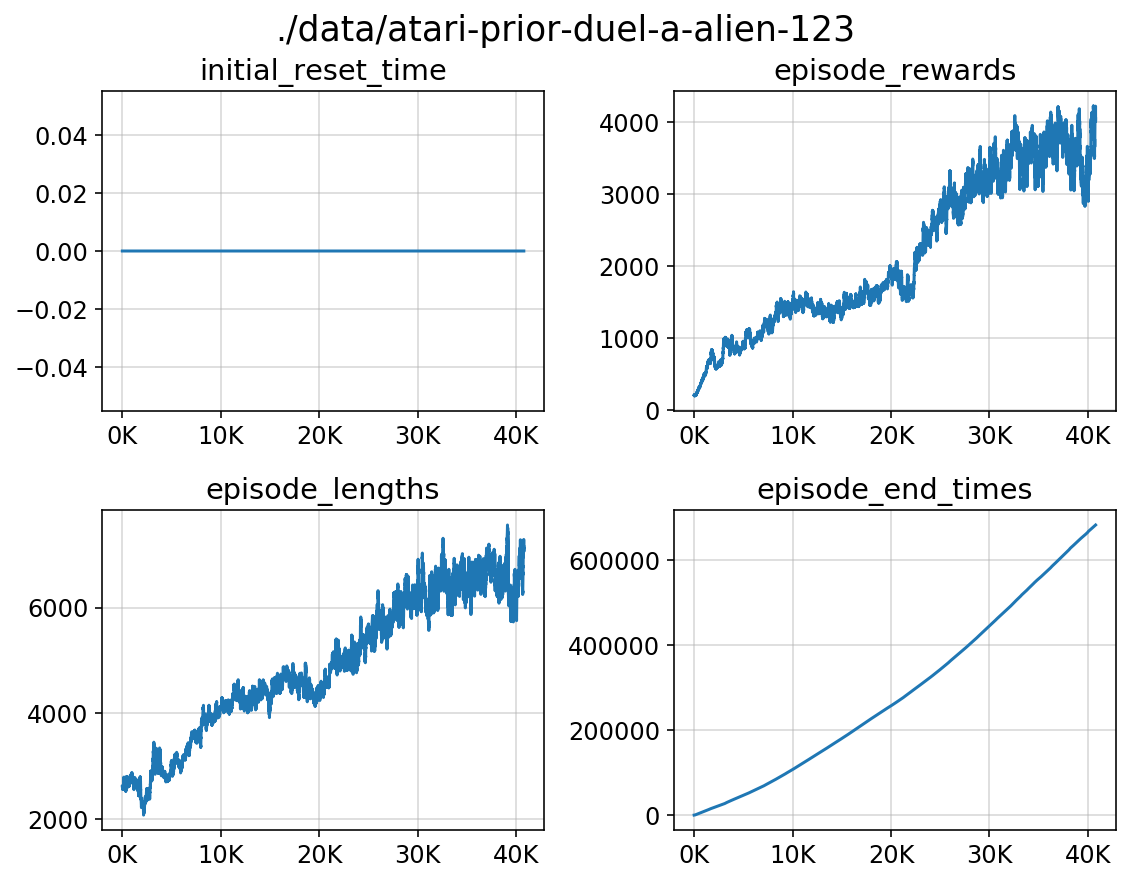

In [10]:
# Let's look at one run consisting of four columns (see Run.plot())
run[0].plot(rolling=100);

### Experiment Data Construction

In [11]:
from expt.data import Hypothesis, Experiment

There are two central data classes in `expt`:
    
- `Hypothesis`: a group of runs that can be averaged as a single entry (e.g. a variant of algorithm with random seeds)
- `Experiment`: a group of `Hypothesis`'s to be compared to one another.

In [12]:
ex = expt.Experiment("Comparison of DQN Variants")
env = 'amidar'

def make_total_timesteps(r: expt.Run) -> expt.Run:
    """A post-processing after parsing the run: for example, we can add a new column."""
    
    # This should be our x-axis. Note that this might be not aligned across different runs
    r.df['total_timesteps'] = r.df['episode_lengths'].cumsum()
    return r

for algo, desc in {"a": "DQN",
                   "duel-a": "Double DQN",
                   "prior-a": "DQN + PER",
                   "prior-duel-a": "Double DQN + PER",
                  }.items():
    runs = expt.get_runs(f"./data/atari-{algo}-{env}-*", progress_bar=None,
                         run_postprocess_fn=make_total_timesteps)
    
    # h = runs.to_hypothesis(name=desc)
    # ex.add_hypothesis(desc, h)
    ex.add_runs(desc, runs=runs)

In [13]:
# Summarize the data: by default, the average over last 10% rows are reported.
ex.summary()

,hypothesis,index,initial_reset_time,episode_lengths,episode_rewards,episode_end_times,total_timesteps
0,DQN,30707,0.0,7324.683550,784.491205,505011.109550,1.920179e+08
1,Double DQN,29188,0.0,8370.229724,1064.562371,609950.799399,1.902990e+08
2,DQN + PER,23912,0.0,12108.668061,1620.768716,555125.618996,1.876133e+08
3,Double DQN + PER,21613,0.0,14784.331328,2192.625405,622450.219563,1.883250e+08


In [14]:
ex.columns

['initial_reset_time',
 'episode_lengths',
 'episode_rewards',
 'episode_end_times',
 'total_timesteps']

## 3. Plotting using Data API

In [15]:
expt.Hypothesis.plot?

Init signature: expt.Hypothesis.plot(hypothesis: 'Hypothesis')
Docstring:     
Hypothesis.plot based on matplotlib.

This can work in two different modes:
(1) Plot (several or all) columns as separate subplots (subplots=True)
(2) Plot (several or all) columns in a single axesplot (subplots=False)

Additional keyword arguments:
    - rolling (int): A window size for rolling and smoothing.
    - n_samples (int): If given, we subsample using n_samples number of
      equidistant points over the x axis. Values will be interpolated.
    - legend (bool, int, str, or dict):
        If True, a legend will be added to each of the subplots.
        Default is False (no legend). If a dict is given, it will be
        passed as kwargs to GridPlot.add_legend(). Please see the
        documentation of `GridPlot.add_legend`.
        If int or str is given, same meaning as `dict(ax=...)`.
    - prettify_labels (bool): If True, apply a sensible default
      prettifier to the legend labels, truncating 

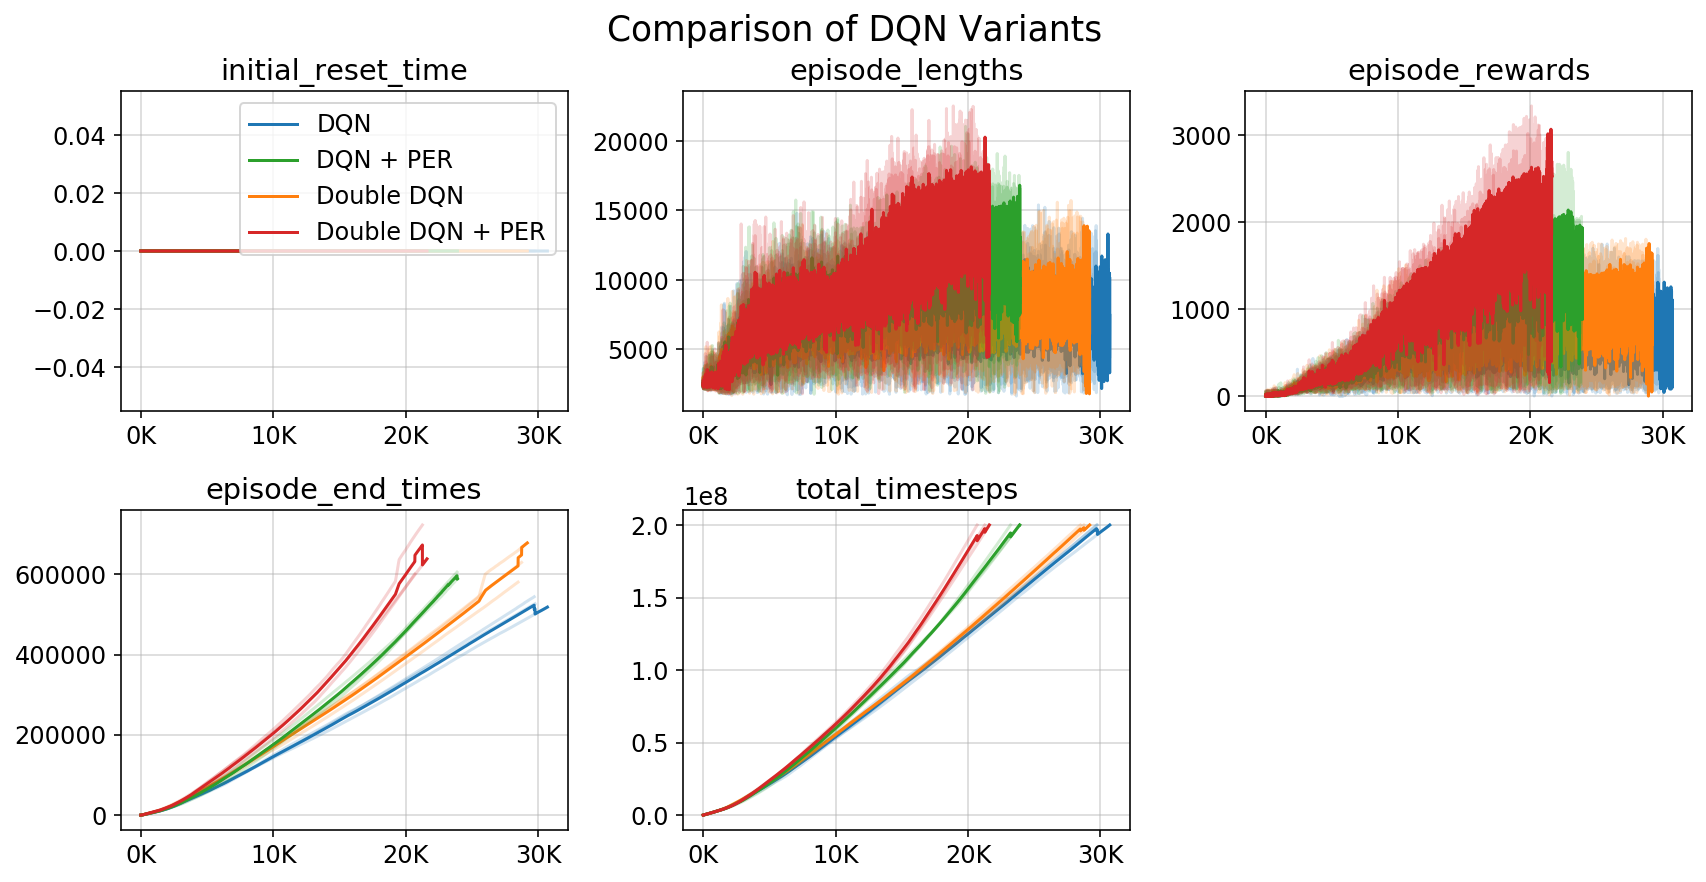

In [16]:
g = ex.plot()

This default one doesn't look quite good -- but should be much better than the default behavior of `DataFrame.plot()`.

We can pass sensible arguments from `DataFrame.plot()`. Other useful ones are `rolling` and `n_samples`, which allow better appearance and faster plotting by sub-sampling and interpolation of the data (it also helps to deal with a x-axis that is not aligned over different random seeds).

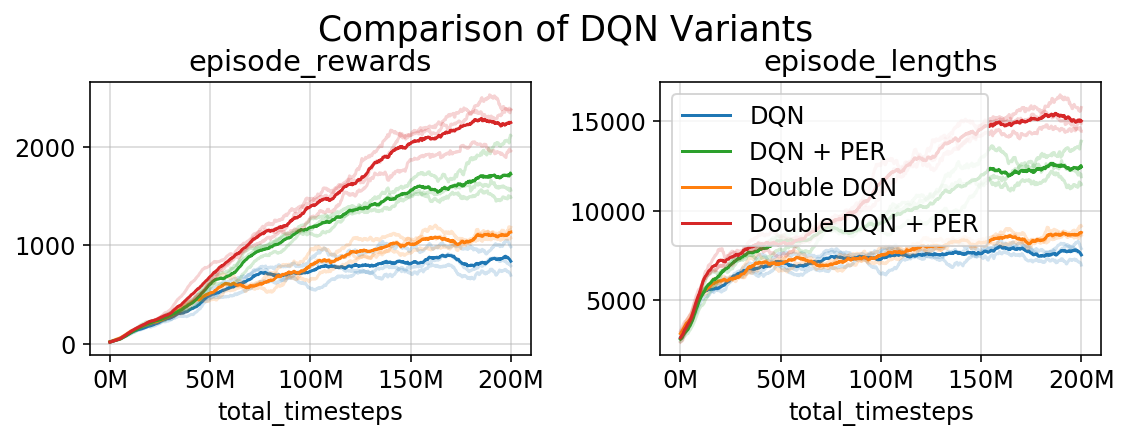

In [17]:
g = ex.plot(x='total_timesteps', y=['episode_rewards', 'episode_lengths'],
            rolling=50, n_samples=1000, legend='episode_lengths')

By default, each individual run (e.g., random seeds) will be shown (`err_style="runs"`, see also `runs_alpha`).

If you would like to draw 1-std confidence interval instead, try `err_style="fill"` (see also `std_alpha`):

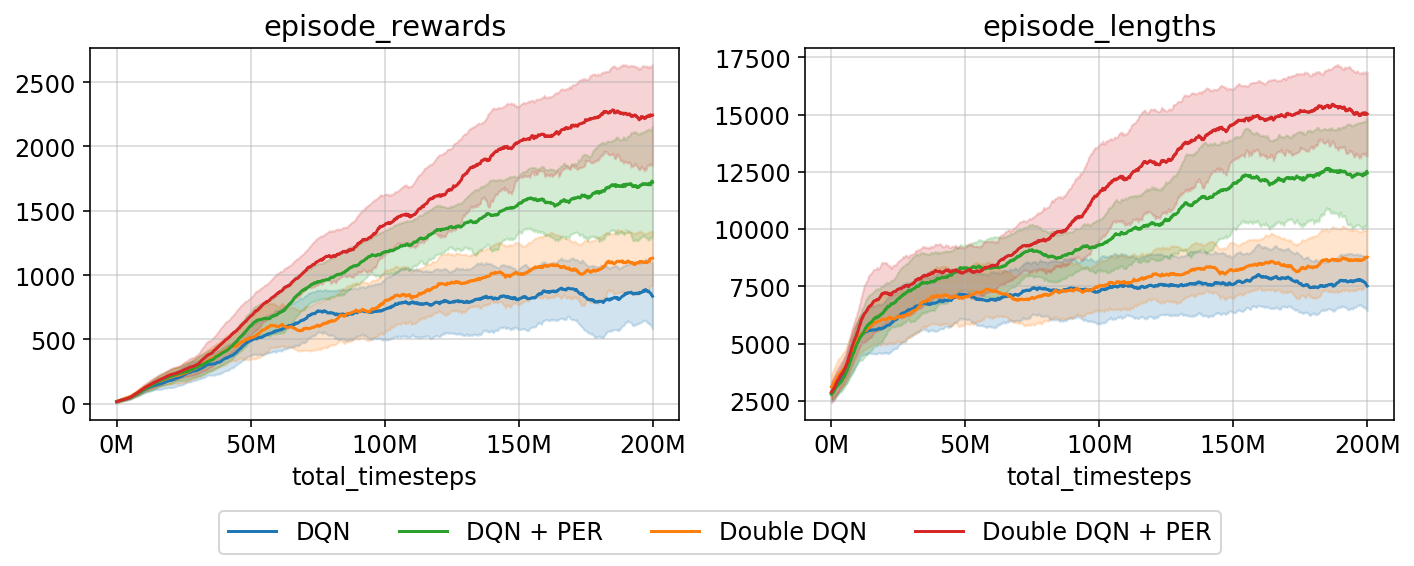

In [18]:
g = ex.plot(x='total_timesteps', y=['episode_rewards', 'episode_lengths'],
            rolling=50, n_samples=1000, err_style="fill",
            legend=False, suptitle="", figsize=(10, 4))

# Optional: add a legend on the figure. The lower center of the legend box should be at (x=0.5, y=0.0)
# To avoid cropping, we should adjust the figure height and subplot regions accoridingly.
# see https://matplotlib.org/3.2.1/api/legend_api.html#matplotlib.legend.Legend
g.add_legend(ax=None, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=4);
g.figure.subplots_adjust(bottom=0.25)

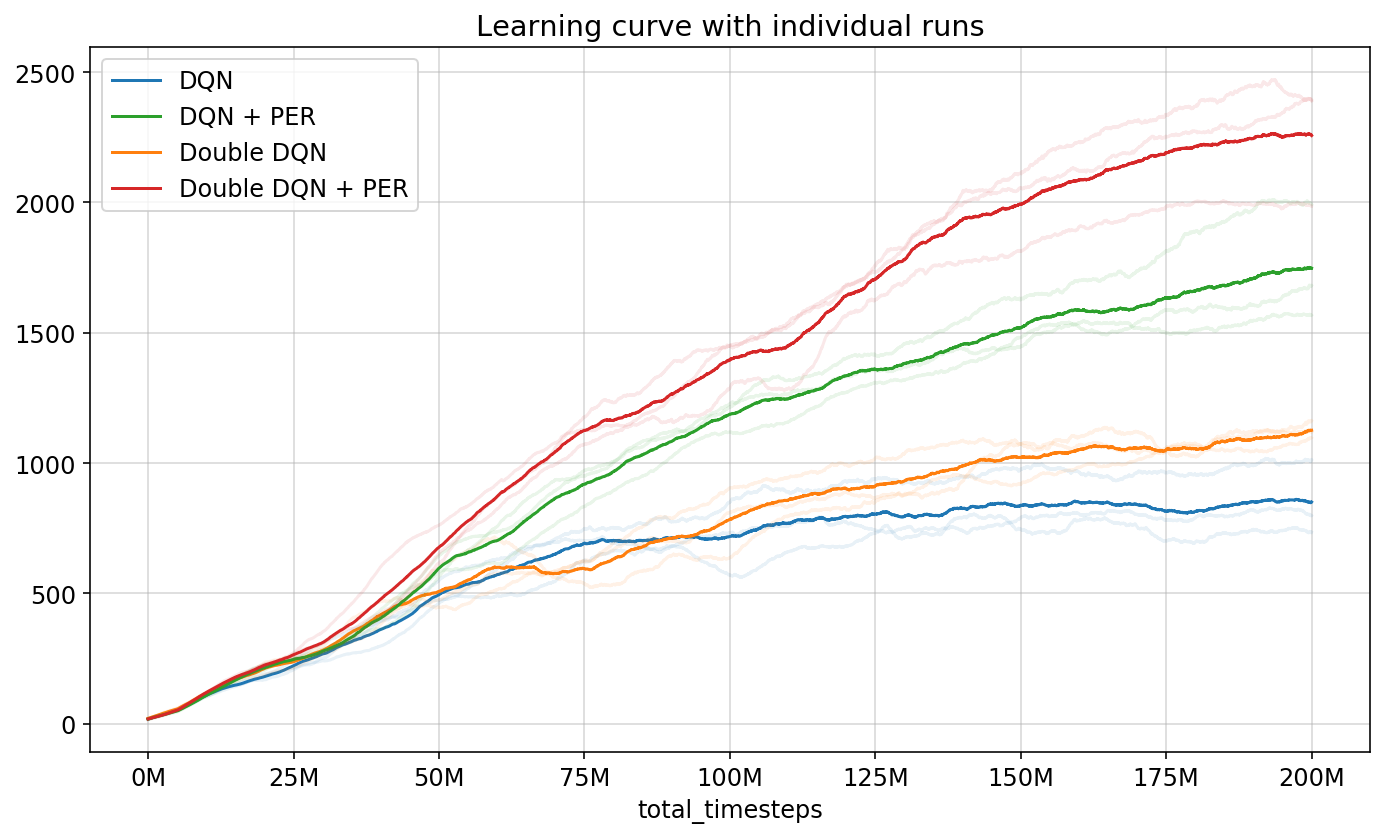

In [19]:
# Draw on existing matplotlib Figure or Axes
fig, ax = plt.subplots(figsize=(10, 6))

ex.plot(x='total_timesteps', y='episode_rewards',
        rolling=500, n_samples=10000,
        err_style='runs', runs_alpha=0.1, 
        suptitle="", ax=ax);

# further customization using matplotlib API
ax.set_title("Learning curve with individual runs")
ax.yaxis.set_label_text("")
fig;

It is also possible to plot individual `Hypothesis` and Run objects:

Hypothesis('DQN', <3 runs>)


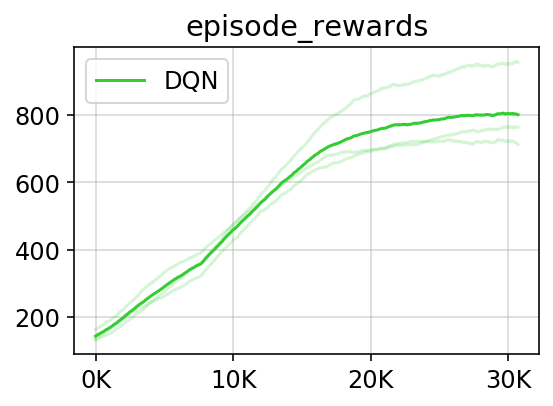

In [20]:
h = ex.hypotheses[0]
print(h)
h.plot(rolling=500, n_samples=1000, y='episode_rewards',
       color='limegreen', suptitle="", legend=True);

## 4. More plotting examples

### 4.1. Organizing raw runs

Let's first collect all runs (255 in total for this example).

In [21]:
runs = expt.get_runs("./data/atari-*").filter(lambda r: 'rb' not in r.name)

# Pre-processing runs
for r in runs:
    r.df['total_timesteps'] = r.df['episode_lengths'].cumsum()
        
print("Length:", len(runs))
print("Sample:", runs[0])
print(" - columns:", list(runs[0].df.columns))


Length: 228
Sample: Run('./data/atari-a-alien-123', df with 50219 rows)
 - columns: ['initial_reset_time', 'episode_rewards', 'episode_lengths', 'episode_end_times', 'total_timesteps']


We will need to group runs by algorithm (hypothesis), environment (or dataset), aggregating over different random seeds into a proper group. We can use pandas-like API to extract control variables from the name of runs:

In [22]:
# Use regex named group to extract columns (e.g. algorithm, env_id, seed) into DataFrames
rt = runs.extract("atari-(?P<algorithm>a|duel-a|prior-a|prior-duel-a)?-(?P<env_id>[a-z]+)-(?P<seed>[0-9]+)")

# Optionally, we can make algorithm have a better name ...
rt['algorithm'] = rt['algorithm'].map({'a': 'DQN',
                                       'duel-a': 'Double DQN',
                                       'prior-a': 'DQN + PER',
                                       'prior-duel-a': 'Double DQN + PER'})
rt

,algorithm,env_id,seed,run
0,DQN,alien,123,"Run('./data/atari-a-alien-123', df with 50219 ..."
1,DQN,alien,456,"Run('./data/atari-a-alien-456', df with 50316 ..."
2,DQN,alien,789,"Run('./data/atari-a-alien-789', df with 51936 ..."
3,DQN,amidar,123,"Run('./data/atari-a-amidar-123', df with 29774..."
4,DQN,amidar,456,"Run('./data/atari-a-amidar-456', df with 29711..."
...,...,...,...,...
223,Double DQN + PER,timepilot,456,"Run('./data/atari-prior-duel-a-timepilot-456',..."
224,Double DQN + PER,timepilot,789,"Run('./data/atari-prior-duel-a-timepilot-789',..."
225,Double DQN + PER,upndown,123,"Run('./data/atari-prior-duel-a-upndown-123', d..."
226,Double DQN + PER,upndown,456,"Run('./data/atari-prior-duel-a-upndown-456', d..."


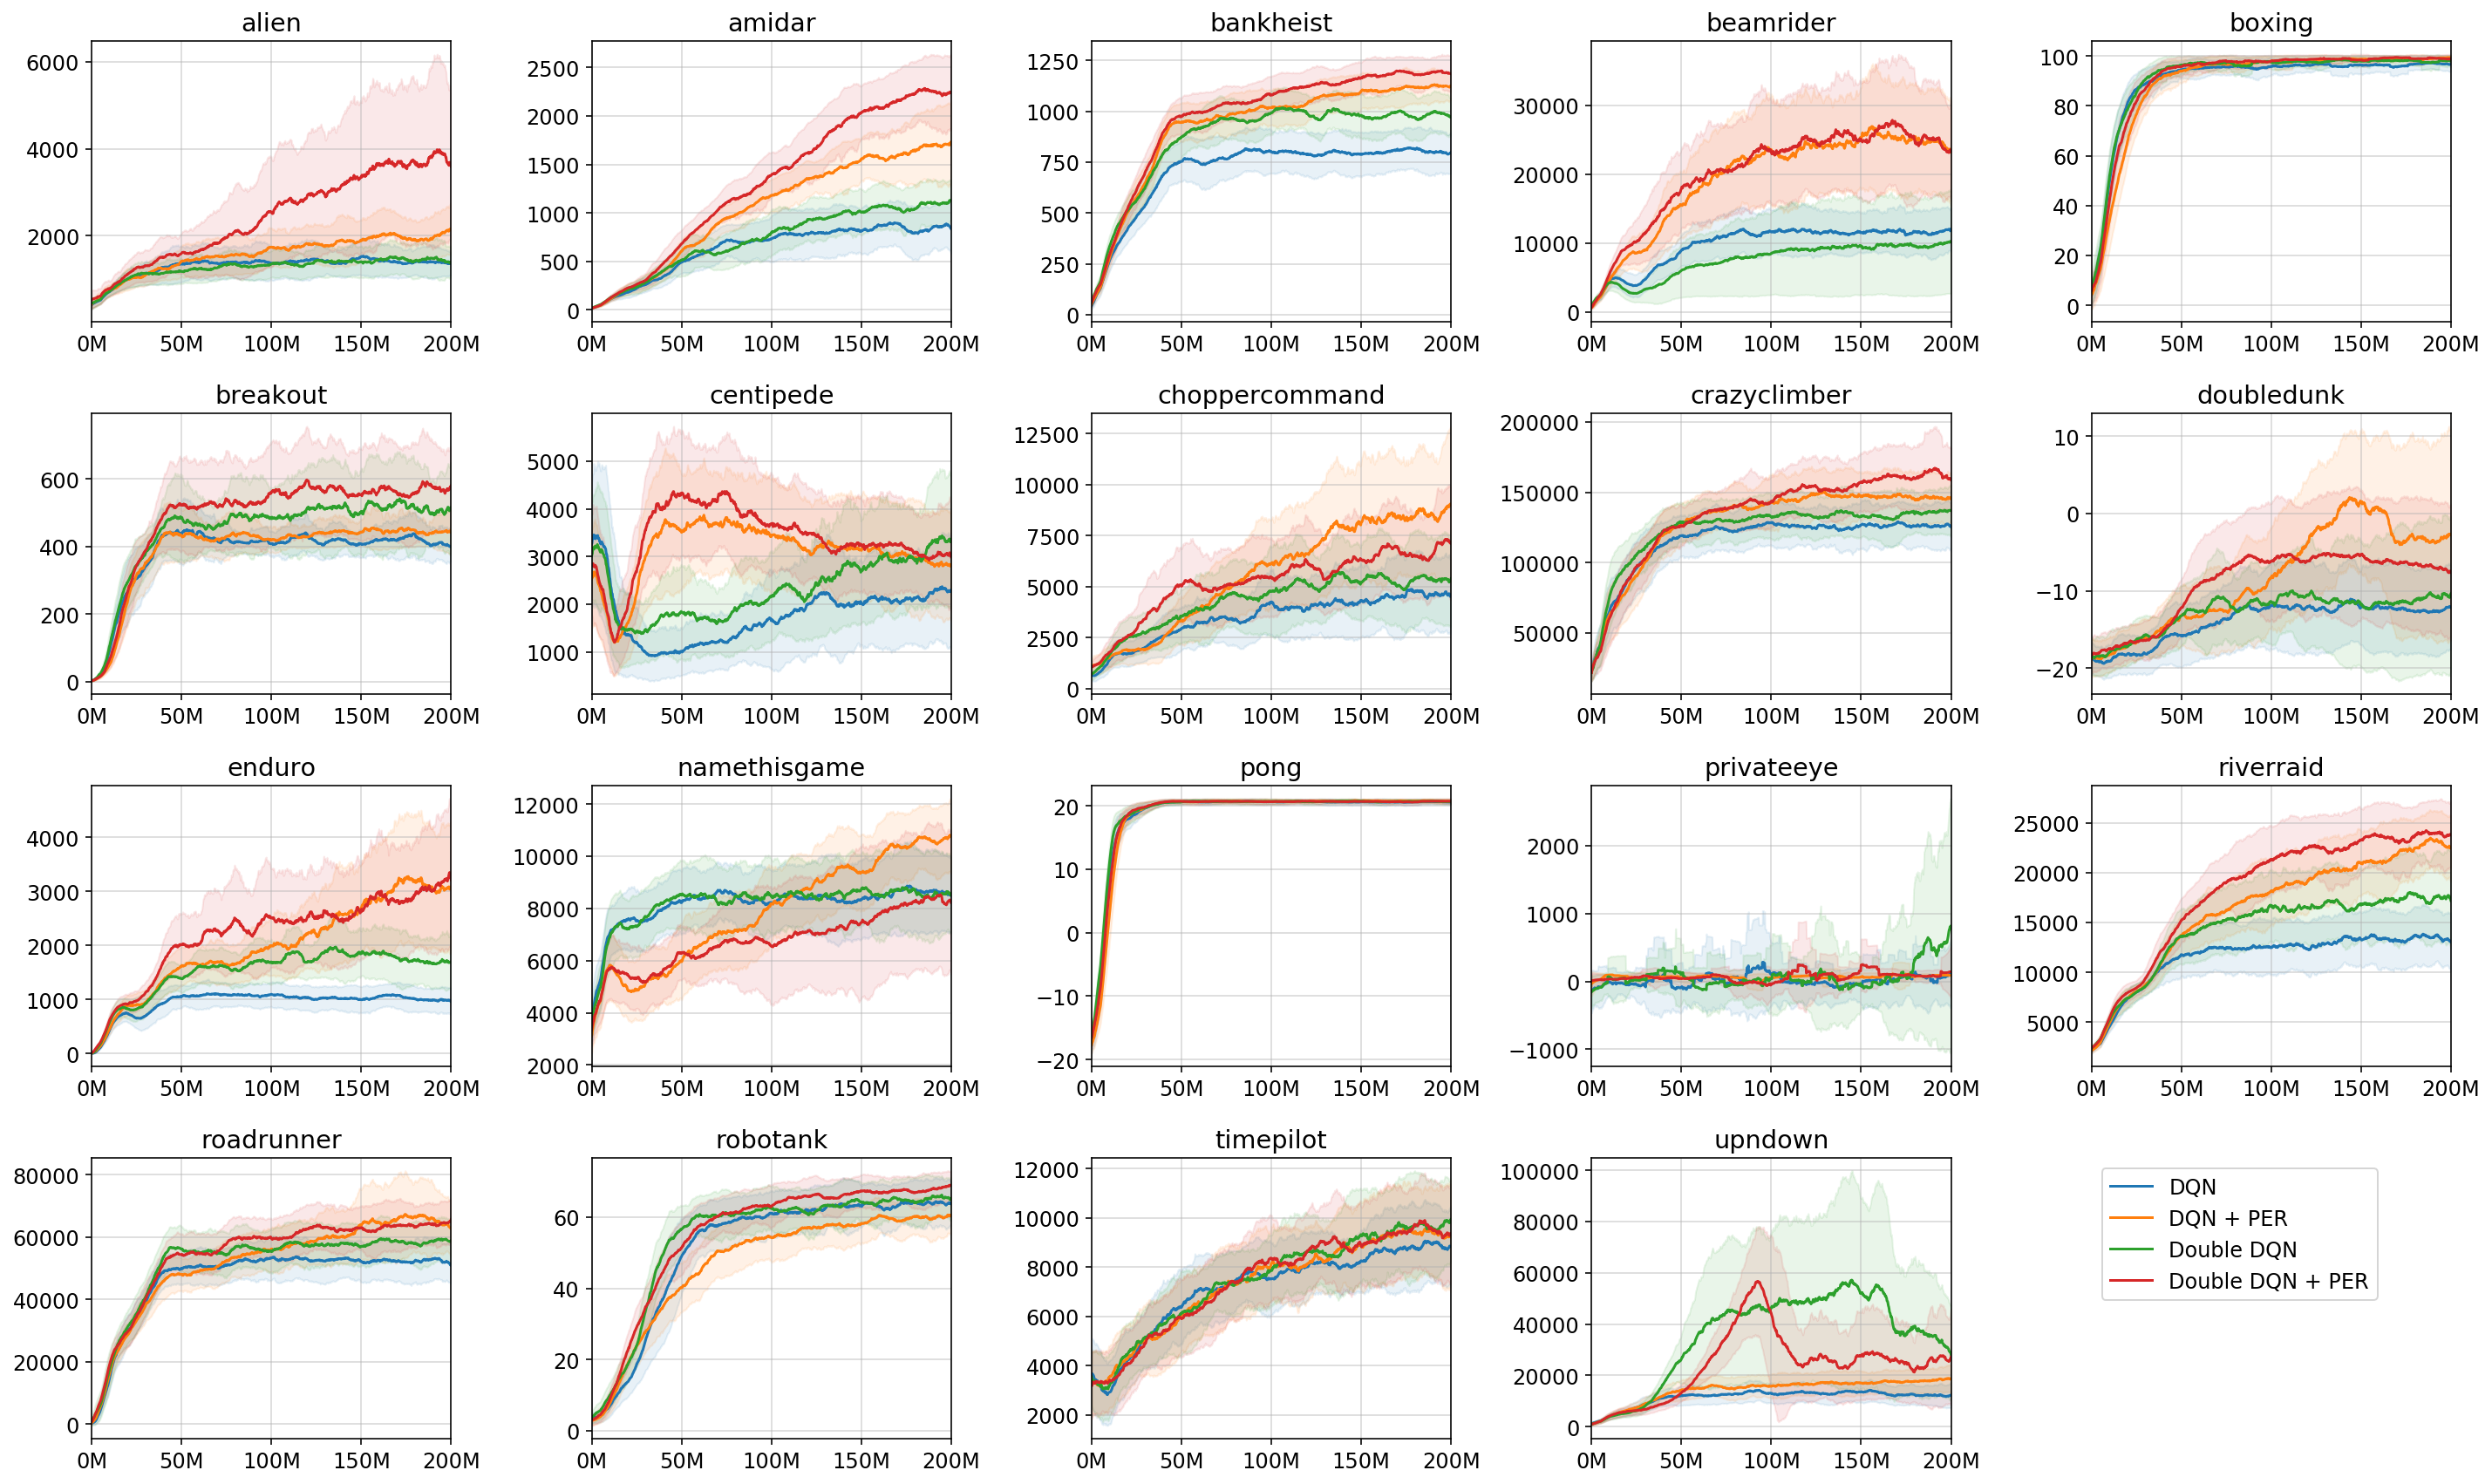

In [23]:
from expt.plot import GridPlot

g = GridPlot(y_names=rt.env_id.unique())

for env_id, t in tqdm(rt.groupby('env_id')):
    ex = Experiment.from_dataframe(t, by='algorithm', name=env_id)
    ex.plot(ax=g[env_id], title=env_id,
            x='total_timesteps', y='episode_rewards',
            err_style='band', std_alpha=0.1,
            rolling=50, n_samples=1000, legend=False,
            tight_layout=False,
           )

# Put a legend on the last empty grid axes
g.add_legend(ax=g.axes[-1, -1], loc="upper left", bbox_to_anchor=(0, 1))

# Some post-processing with matplotlib API so that the plot looks nicer
for ax in g.axes_active:
    ax.xaxis.set_label_text("")
    ax.yaxis.set_label_text("")
    ax.set_xlim(0, 200e6)

g.fig.tight_layout(h_pad=1.3, w_pad=1.0)
g.fig;

## 5. Holoviews (Experimental)

Matplotlib is great, but slow. Interactive plotting libraries such as `bokeh`, `plotly` would be awesome. For now, we provide a high-level API based on hvplot (Holoviews) with almost similar interfaces.

In [ ]:
# Holoviews+Plotly.express extension (faster than matplotlib)
# !pip install -U panel hvplot 'bokeh>=2.0.0' 'holoviews>=1.13.0'
import hvplot.pandas
import holoviews as hv

#hv.output(backend="plotly")           # options: 'bokeh', 'plotly'

#import plotly.io as pio
#pio.templates.default = "none"

In [ ]:
p = ex.hvplot(x="total_timesteps", 
              y=["episode_rewards", "episode_lengths"],
              rolling=500, n_samples=5000, err_style='fill',
              width=400, height=300,
              legend='episode_lengths')

# http://holoviews.org/user_guide/Customizing_Plots.html
p.cols(2)